# Implementierung einer Künstlichen Intelligenz für das Spiel Othello

## Initiale Konfiguration

Importieren von Abhängigkeiten und Konfiguration

Die Implementierung der Spielelogik findet in einem separaten Jupyter Notebook statt. Diese wird deshalb hier zunächst ausgeführt.

In [ ]:
%run othello_game.ipynb

In [ ]:
import math
import copy
import time
import numpy
import random

## Heuristiken

Zum Abschätzen der Nützlichkeit eines Spielzustands wird eine Heuristik benötigt. Im folgenden sind einige solcher Heuristiken implementiert. Da Weiß der maximierende Spieler, und Schwarz der minimierende Spieler ist repräsentiert ein höherer Wert der Heuristik einen für Weiß vorteilhaften Zug, während ein niedriger Wert einen Vorteil für Schwarz repräsentiert. Die Werte der Heuristik liegen zwischen -1 und 1, wobei die Randwerte einen garantierten Sieg für den jeweiligen Spieler darstellen. Der Wert 0 steht für einen für beide Spieler gleich guten Spielzustand.

Da das Ziel des Spiels Othello ist, zum Ende des Spiels mehr Steine als der Gegner auf dem Spielfeld zu haben, ist es naheliegend, die Differez der Anzahlen von Steinen beider Spieler zur Abschätzung eines Zuges zu verwenden. Genau das macht die Disk-Count-Heuristik indem sie die Differenz der Steine, beider Spieler berechnet und den resultierenden Wert zur Normalisierung durch die maximale Anzahl an Steinen teilt. Bei genauerer Betrachtung ist es jedoch, gerade zu Beginn des Spiels nicht immer vorteilhaft, den Vorsprung an Steinen zu maximieren.

In [ ]:
def disc_count_heuristic(state):
    return (count_disks(state, WHITE) - count_disks(state, BLACK)) / 64

Eine weitere Heuristik ist die Mobilität der Spieler. Diese gibt an wie viele mögliche Züge ein Spieler gegenüber dessen Gegner machen kann. Die Idee bei dieser Heuristik ist, dass ein Spieler dadurch seine Freiheit maximiert, während die Freiheit des Gegners durch eine geringe Anzahl an Zügen eingeschränkt wird. Die Mobilitäts-Heuristik gibt an wie viele möglicher Züge mehr Weiß gegenüber Schwarz im Aktuellen Spielzustand hat. Auch dieser Wert wird durch Division durch die Anzahl an Feldern normalisiert, um die Grenzen von -1 und 1 einzuhalten.

In [ ]:
def mobility_heuristic(state):
    if state.turn == WHITE:
        return (len(state.possible_moves) - len(get_possible_moves(state, BLACK))) / 64
    else:
        return (len(get_possible_moves(state, WHITE)) - len(state.possible_moves)) / 64

Beim Spielen von Othello fällt auf, dass es bestimmte Felder gibt, deren Belegung von Vorteil ist, sowie einige, deren Belegung eher nachteilhaft ist. Diese Eigenschaft macht sich die Weight-Heuristik zu Nutze. Diese weist jedem Feld einen Wert zu der angibt, wie Vorteilhaft der Besitz dieses Feldes ist, bzw. wie Nachteilhaft die Belegung des Feldes durch den Gegner ist. Diese Gewichte werden dann mit der aktuellen Belegung des Spielfelds multipliziert und die Ergebnisse anschließend aufsummiert. Der resultierende Wert schätzt dann den Nutzen der aktuellen Position ein. Auch bei dieser Heuristik findet eine Normalisierung statt.

Aufgrund der Symmetrie des Othello Spielfeldes ist es für die Weight-Heuristik nicht nötig, für jedes Feld einzeln dessen Gewicht anzugeben, stattdessen wird das Gewicht jeweils für charakteristische felder, wie zum Beispiel die Ecken, angegeben. Die Funktion `gen_weight_matrix` generiert dann die Gewichte-Matrix für das gesamte Feld und führt auch die Normalisierung durch.

In [ ]:
def gen_weight_matrix(default=0, corner=0, adj_corner=0, sup_corner=0, edge=0, dia_corner=0, support=0, sup_edge=0):
    raw_matrix = numpy.array([
        [corner,      adj_corner,  sup_corner,  edge,      edge,      sup_corner,  adj_corner,  corner],
        [adj_corner,  dia_corner,  default,     default,   default,   default,     dia_corner,  adj_corner],
        [sup_corner,  default,     support,     sup_edge,  sup_edge,  support,     default,     sup_corner],
        [edge,        default,     sup_edge,    default,   default,   sup_edge,    default,     edge],
        [edge,        default,     sup_edge,    default,   default,   sup_edge,    default,     edge],
        [sup_corner,  default,     support,     sup_edge,  sup_edge,  support,     default,     sup_corner],
        [adj_corner,  dia_corner,  default,     default,   default,   default,     dia_corner,  adj_corner],
        [corner,      adj_corner,  sup_corner,  edge,      edge,      sup_corner,  adj_corner,  corner]
    ])
    max_possible = numpy.sum(numpy.absolute(raw_matrix))
    return numpy.true_divide(raw_matrix, max_possible)

Die Funktion `weight_heuristic` berechnet die Weight-Heuristik allgemein für eine Gewichte-Matrix

In [ ]:
def weight_heuristic(state, weights):
    return numpy.sum(numpy.multiply(state.board, weights))

Die Gewichte-Matrix `cowthello_weights` nutzt die Gewichte aus dem Online-Othello Programm Cowthello. Cowthello ist unter der URL <https://www.aurochs.org/games/cowthello/> verfügbar.

In [ ]:
cowthello_weights = gen_weight_matrix(default=1, corner=100, adj_corner=-25, sup_corner=25, edge=10, dia_corner=-50, support=50, sup_edge=5)

Die Funktion `cowthello_heuristic` ist eine Weight-Heuristik welche die Gewichte-Matrix von Cowthello verwendet.

In [ ]:
def cowthello_heuristic(state):
    return weight_heuristic(state, cowthello_weights)

Die oben implementierten Heuristiken bewerten jeweils nur ein Merkmal der aktuellen Spielsitation. Durch eine Kombination mehrerer dieser Heuristiken können mehrere Merkmale gleichzeitig betrachtet werden. Die Kombination der Heuristiken kann in Abhängigkeit der aktuellen Spielphase geschehen. Beispielsweise wird zu Ende des Spiels die Disc-Count-Heuristik wichtiger.

In [ ]:
def combined_heuristic(state):
    if(state.num_pieces >= 50):
        return disc_count_heuristic(state)
    mobility = mobility_heuristic(state)
    cowthello = cowthello_heuristic(state)
    return (mobility + cowthello) / 2

## Implementierung der Strategien

### Zufällige KI
Diese KI wählt aus der Menge der Möglichen Züge einen zufälligen aus und spielt diesen.

In [ ]:
def random_ai_make_move(state, heuristic):
    possible_moves = state.possible_moves
    random_move = random.choice(possible_moves)
    make_move(state, random_move[0], random_move[1])

### Minimax KI
Diese KI verwendet den Minimax Algorithmus zur Bestimmung der Nützlichkeit eines Zuges.

In [ ]:
MINIMAX_DEPTH_LIMIT = 3
debug_mm_count= 0

def minimax(state, depth, heuristic):
    global debug_mm_count
    if(state.game_over):
        return get_winner(state)
    if(depth <= 0):
        return heuristic(state)
    
    if state.turn == WHITE:
        # maximizing
        utility = -math.inf
    else:
        # minimizing
        utility = math.inf
        
    for move in get_possible_moves(state, state.turn):
        debug_mm_count += 1
        tmp_state = copy.deepcopy(state)
        make_move(tmp_state, move[0], move[1])
        tmp_utility = minimax(tmp_state, depth - 1, heuristic)
        if state.turn == WHITE:
            # maximizing
            utility = max(utility, tmp_utility)
        else:
            # minimizing
            utility = min(utility, tmp_utility)          
    return utility

Für alle möglichen Züge wird die Nützlichkeit des resultierenden Zustands mithilfe von `minimax` bestimmt und aus allen Zügen mit einer, für den Spieler optimalen, Nützlichkeit ein zufälliger Zug ausgewählt.

In [ ]:
def minimax_ai_make_move(state, heuristic):
    if(state.game_over):
        return
    scored_moves = [(minimax(make_move(copy.deepcopy(state), move[0], move[1]), MINIMAX_DEPTH_LIMIT-1, heuristic), move) for move in state.possible_moves]
    if state.turn == WHITE:
        # maximizing
        best_score, _ = max(scored_moves)
    else:
        # minimizing
        best_score, _ = min(scored_moves)
    best_move = random.choice([move for move in scored_moves if move[0] == best_score])[1]
    make_move(state, best_move[0], best_move[1])

### Alpha-Beta KI
Diese KI verwended den Minimax Algorithmus mit der Optimierung Alpha-Beta Pruning, um die Nützlichkeit eines Spielzustands zu bestimmen.

Zum Merken vorheriger Ausführungen von wird das Dictionary `transposition_table` verwendet. Dies ist gerade bei der Verwendung von Iterative Deepening für das Move-Ordering vorteilhaft. Der Schlüssel des Dictionaries besteht aus dem Zustand des Spielbretts, dem Spieler, der an der Reihe ist und der verwendeten Heuristik.

In [ ]:
transposition_table = {}

Die Funktion `alphabeta` implementiert den Minimax Algorithmus mit Alpha-Beta-Pruning

In [ ]:
ALPHABETA_DEPTH_LIMIT = 3
debug_ab_count= 0

def alphabeta(state, depth, alpha, beta, heuristic):
    global debug_ab_count
    if(state.game_over):
        return get_winner(state)
    if(depth <= 0):
        return heuristic(state)
    
    moves = get_possible_moves(state, state.turn)
    child_states = [make_move(copy.deepcopy(state), move[0], move[1]) for move in moves]
    estimated_utilities = [transposition_table[(child_state.board.tobytes(), child_state.turn, heuristic)]
                           if (child_state.board.tobytes(), child_state.turn, heuristic) in transposition_table
                           else heuristic(state)
                           for child_state in child_states]
    ordered_moves = [(estimated_utilities[i], child_states[i]) for i in range(len(moves))]
    ordered_moves.sort(reverse=(state.turn == WHITE))
    
    if state.turn == WHITE:
        # maximizing
        utility = -math.inf
    else:
        # minimizing
        utility = math.inf
        
    for (_, tmp_state) in ordered_moves:
        debug_ab_count += 1
        tmp_utility = alphabeta(tmp_state, depth - 1, alpha, beta, heuristic)
        transposition_table[(tmp_state.board.tobytes(), tmp_state.turn, heuristic)] = tmp_utility
        
        if state.turn == WHITE:
            # maximizing
            utility = max(utility, tmp_utility)
            alpha = max(alpha, utility)
        else:
            # minimizing
            utility = min(utility, tmp_utility)
            beta = min(beta, utility)
        if(alpha >= beta):
            break # alphabeta pruning
    return utility

Wie bei der Minimax KI wird auch bei der Alpha-Beta KI für alle möglichen Züge wird die Nützlichkeit des resultierenden Zustands bestimmt, hier mithilfe von von `alphabeta`, und aus allen Zügen mit einer, für den Spieler optimalen, Nützlichkeit ein zufälliger Zug ausgewählt.

In [ ]:
def alphabeta_ai_make_move(state, heuristic):
    if(state.game_over):
        return
    scored_moves = [(alphabeta(make_move(copy.deepcopy(state), move[0], move[1]), ALPHABETA_DEPTH_LIMIT-1, -math.inf, math.inf, heuristic), move) for move in state.possible_moves]
    if state.turn == WHITE:
        # maximizing
        best_score, _ = max(scored_moves)
    else:
        # minimizing
        best_score, _ = min(scored_moves)
    best_move = random.choice([move for move in scored_moves if move[0] == best_score])[1]
    make_move(state, best_move[0], best_move[1])

Beim Iterative Deepening wird der Alphabeta-Algorithmus nacheinander mit steigender Tiefe ausgeführt. Die Werte aus der vorherigen Ausführung werden dann für das Move-Ordering verwendet. Dadurch das bessere Move-Ordering können beim Alpha-Beta-Pruning mehr Zweige abgeschnitten werden. Dadurch kann trotz der mehrfachen Ausführung eine höhere Performanz bei gleichem Ergebnis erreicht werden. Ein weiterer Vorteil ist, dass das Iterative Deepening jederzeit abgebrochen werden kann. Dadurch kann in einer vorgegebenen Zeit, die in dieser Zeit maximal mögliche Suchtiefe erreicht werden.

In [ ]:
def alphabeta_id_make_move(state, heuristic):
    best_move = None
    depth = 1
    while depth <= ALPHABETA_DEPTH_LIMIT:
        scored_moves = [(alphabeta(make_move(copy.deepcopy(state), move[0], move[1]), depth-1, -math.inf, math.inf, heuristic), move) for move in state.possible_moves]
        if state.turn == WHITE:
            # maximizing
            best_score, _ = max(scored_moves)
        else:
            # minimizing
            best_score, _ = min(scored_moves)
        best_move = random.choice([move for move in scored_moves if move[0] == best_score])[1]
        depth += 1
    make_move(state, best_move[0], best_move[1])

Beim Iterative Deepening ist jederzeit der beste Zug der letzten Suchtiefe bekannt. Daher kann der Algorithmus verwendet werden, um in einer vorgegebenen Zeit mit größtmöglicher Suchtiefe zu suchen. Dazu wird die Dauer des nächsten Zugs anhand der Dauer des letzten Zugs geschätzt. Somit kann es vorkommen, dass die Berechnung etwas länger oder kürzer als die gegebene Zeit dauert. Dafür wird das Ergebnis aller Berechnungen verwendet und die letzte Suche muss nicht abgebrochen werden.

In [ ]:
MAX_SECS_PER_MOVE = 30

def alphabeta_id_make_move_timelimited(state, heuristic):
    best_move = None
    depth = 1
    start = time.time()
    last_time = 0
    while MAX_SECS_PER_MOVE - (time.time() - start) >= 4 * last_time:
        last_time_start = time.time()
        scored_moves = [(alphabeta(make_move(copy.deepcopy(state), move[0], move[1]), depth-1, -math.inf, math.inf, heuristic), move) for move in state.possible_moves]
        if state.turn == WHITE:
            # maximizing
            best_score, _ = max(scored_moves)
        else:
            # minimizing
            best_score, _ = min(scored_moves)
        best_move = random.choice([move for move in scored_moves if move[0] == best_score])[1]
        last_time = time.time() - last_time_start
        depth += 1
    print("Reached depth: ", depth-1)
    make_move(state, best_move[0], best_move[1])

### ProbCut KI
An dieser Stelle beginnt die Implementierung der Künstlichen Intelligenz mittels des Minimax Algorithmus und ProbCut

In [ ]:
PERCENTILE = 1.5 # 93.3%
PROBCUT_SHALLOW_DEPTH = 2
PROBCUT_DEPTH = 4
PROBCUT_SIGMA = 0.05

In [ ]:
debug_pc_count= 0

def probcut(state, depth, alpha, beta, heuristic):
    global debug_pc_count
    if(state.game_over):
        return get_winner(state)
    if(depth <= 0):
        return heuristic(state)
    
    if depth == PROBCUT_DEPTH:
        if state.num_pieces <= 45: # if there are not more than 45 pieces on the board sigma can be calculated based on statistic values with the combined_heuristic
            sigma = state.num_pieces * 0.001948723205790693 - 0.001604049443613545
            # v >= beta with prob. of at least p? yes => cutoff
            bound = PERCENTILE * sigma + beta
            if probcut(state, PROBCUT_SHALLOW_DEPTH, bound-1, bound, heuristic) >= bound:
                return beta

            # v <= alpha with prob. of at least p? yes => cutoff
            bound = -PERCENTILE * sigma + alpha
            if probcut(state, PROBCUT_SHALLOW_DEPTH, bound, bound+1, heuristic) <= bound:
                return alpha
    
    moves = get_possible_moves(state, state.turn)
    child_states = [make_move(copy.deepcopy(state), move[0], move[1]) for move in moves]
    estimated_utilities = [transposition_table[(child_state.board.tobytes(), child_state.turn, heuristic)]
                           if (child_state.board.tobytes(), child_state.turn, heuristic) in transposition_table
                           else heuristic(state)
                           for child_state in child_states]
    ordered_moves = [(estimated_utilities[i], child_states[i]) for i in range(len(moves))]
    ordered_moves.sort(reverse=(state.turn == WHITE))
    
    if state.turn == WHITE:
        # maximizing
        utility = -math.inf
    else:
        # minimizing
        utility = math.inf
        
    for (_, tmp_state) in ordered_moves:
        debug_pc_count += 1
        tmp_utility = probcut(tmp_state, depth - 1, alpha, beta, heuristic)
        transposition_table[(tmp_state.board.tobytes(), tmp_state.turn, heuristic)] = tmp_utility
        
        if state.turn == WHITE:
            # maximizing
            utility = max(utility, tmp_utility)
            alpha = max(alpha, utility)
        else:
            # minimizing
            utility = min(utility, tmp_utility)
            beta = min(beta, utility)
        if(alpha >= beta):
            break # alphabeta pruning
    return utility

In [ ]:
def probcut_ai_make_move(state, heuristic):
    if(state.game_over):
        return
    scored_moves = [(probcut(make_move(copy.deepcopy(state), move[0], move[1]), PROBCUT_DEPTH-1, -math.inf, math.inf, heuristic), move) for move in state.possible_moves]
    if state.turn == WHITE:
        # maximizing
        best_score, _ = max(scored_moves)
    else:
        # minimizing
        best_score, _ = min(scored_moves)
    best_move = random.choice([move for move in scored_moves if move[0] == best_score])[1]
    make_move(state, best_move[0], best_move[1])

#### Ermitteln der Standardabweichung
Im Folgenden werden zunächst einige Datenpunkte gesammelt, indem in verschiedenen Spielzuständen jeweils eine tiefe, und eine flache Suche durchgeführt wird. Die Spielzustände werden durch zufälliges Ziehen erreicht.

In [ ]:
import csv
import os

filename = f'probcut_dataset_{PROBCUT_SHALLOW_DEPTH}_{PROBCUT_DEPTH}.csv'

file_empty = not os.path.isfile(filename) or os.stat(filename).st_size == 0
with open(filename, 'a+', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    if file_empty:
        writer.writerow(('moves', 'shallow', 'deep'))
    while True:
        state = GameState()
        try:
            while not state.game_over:
                random_ai_make_move(state, None)
                shallow_value = alphabeta(state, PROBCUT_SHALLOW_DEPTH, -math.inf, math.inf, combined_heuristic)
                deep_value = alphabeta(state, PROBCUT_DEPTH, -math.inf, math.inf, combined_heuristic)
                print(f'shallow: {shallow_value}, deep: {deep_value}')
                writer.writerow((state.num_pieces, shallow_value, deep_value)) 
        except KeyboardInterrupt:
            file.close()

Daten Laden

In [1]:
import pandas
filename = 'probcut_dataset_2_4.csv'
df = pandas.read_csv(filename)
shallow = df['shallow']
deep = df['deep']

Berechnung der Standardabweichung nach Anzahl der Steine auf dem Spielfeld

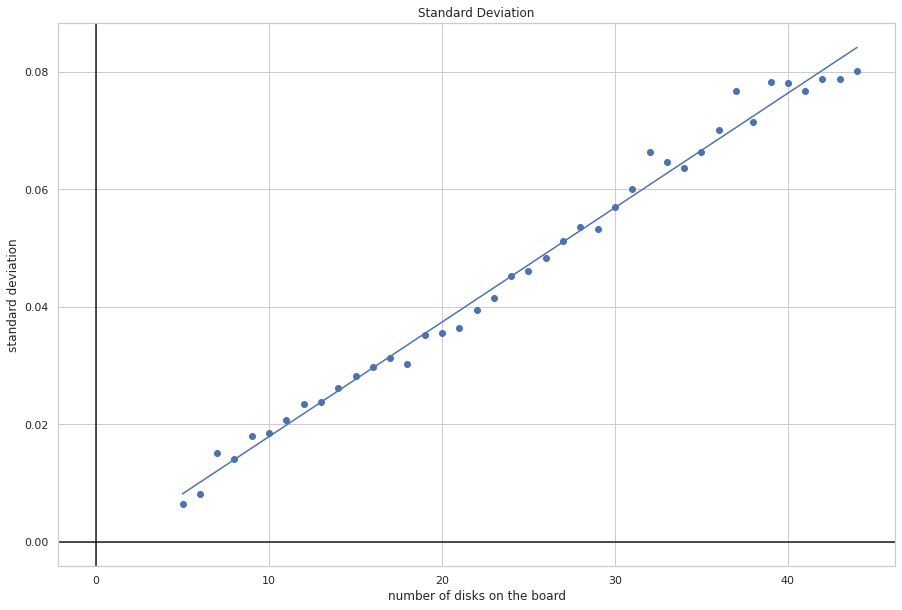

x * 0.001948723205790693 + -0.001604049443613545


In [2]:
import numpy as np
import sklearn.metrics as skl
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
import math

shallow_np = np.array(shallow)
deep_np = np.array(deep)
moves = np.array(df['moves'])

x = []
y = []

for i in range(45-5):
    shallow_c = shallow[moves == i+5]
    deep_c = deep[moves == i+5]
    variance = np.var(np.stack([shallow_c, deep_c], axis=1))
    explained_variance = skl.explained_variance_score(shallow_c, deep_c)
    x.append(i+5)
    y.append(math.sqrt(variance))
    
model = lm.LinearRegression()
model.fit(np.array(x).reshape(-1, 1), np.array(y))

plt.figure(figsize=(15, 10))
sns.set(style='whitegrid')
plt.scatter(x, y)
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.plot(x, x * model.coef_ + model.intercept_)
plt.xlabel('number of disks on the board')
plt.ylabel('standard deviation')
plt.title('Standard Deviation')
plt.show()

print('x *', model.coef_[0], '+', model.intercept_)

#### Daten Visualisieren

In [ ]:
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import seaborn as sns
model = lm.LinearRegression()
model.fit(shallow.values.reshape(len(shallow), 1), deep)
plt.figure(figsize=(15, 10))
sns.set(style='whitegrid')
plt.scatter(shallow, deep)
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.plot(shallow, shallow * model.coef_ + model.intercept_)
plt.xlabel('shallow search')
plt.ylabel('deep search')
plt.title('Probcut Values')
plt.show()

Varianz, erklärte Varianz und Standardabweichung berechnen

In [ ]:
import numpy as np
import sklearn.metrics as skl
variance = np.var(np.stack([shallow, deep], axis=1))
print(f'variance: {variance}')
explained_variance = skl.explained_variance_score(shallow, deep)
print(f'standard distribution: {np.sqrt(variance)}')
print(f'explained variance: {explained_variance}')

### Applikation Starten

Im folgenden wird für beide Spieler die zu verwendende Künstliche Intelligenz, sowie die jeweils angewandte Heuristik festgelegt. Ein Wert von `None` bei der KI steht hierbei für einen menschlichen Spieler. Die KIs und Heuristiken werden jeweils in einem Dictionary gespeicher, sodass mit Spieler als Index auf die entsprechende KI oder Heuristik zugegriffen werden kann.

In [ ]:
# Settings
BLACK_PLAYER_AI = random_ai_make_move
WHITE_PLAYER_AI = probcut_ai_make_move

BLACK_PLAYER_HEURISTIC = combined_heuristic
WHITE_PLAYER_HEURISTIC = combined_heuristic

PLAYER_AI = {BLACK: BLACK_PLAYER_AI, WHITE: WHITE_PLAYER_AI}
PLAYER_HEURISTIC = {BLACK: BLACK_PLAYER_HEURISTIC, WHITE: WHITE_PLAYER_HEURISTIC}

Folgender Code dient zum Starten der interaktiven Applikation. Die Funktion `next_move` wird für jeden Spielzug ausgeführt. Sie wird zu Beginn einmal aufgerufen. Wenn eine KI spielt, wird die Funktion rekursiv für den nächsten Zug aufgerufen. Wenn der Spieler menschlich ist, muss die Ausführung unterbrochen werden, da auf das Aufrufen eines Callbacks durch einen Klick gewartet werden muss. Im Callback wird auch die Funktion `next_move` für den nächsten Zug aufgerufen.

In [ ]:
state = GameState()
display_board(state)

def next_move(state):
    # Check if/which AI is playing
    strat = PLAYER_AI[state.turn]
    if strat is not None:
        time.sleep(0.2)
        strat(state, PLAYER_HEURISTIC[state.turn])
        update_output(state)
        if not state.game_over:
            next_move(state)

try:
    next_move(state)
except KeyboardInterrupt:
    pass

### Testing code

Der folgende Code dient zum Test, sowie zum Debuggen der oben implementierten Funktionen.

In [ ]:
test_board = GameState()

In [ ]:
alphabeta_ai_make_move(test_board, combined_heuristic)
test_board.board

Mit Hilfe des Pakets `cProfile` lassen sich Statistiken darüber sammeln, wie viel Zeit in welchen Funktionen benötigt wird.

In [ ]:
import cProfile

cProfile.run('alphabeta_ai_make_move(test_board, combined_heuristic)')
test_board.board

Die Funktion `debug_num_visited_states` berechnet für einen Spielzustand den nächsten Zug mit verschiedenen Algorithmen und misst dabei die benötigte Zeit. Zusätzlich werden mit den globalen Variablen `debug_mm_count` und  `debug_ab_count` die Anzahl der überprüften Zustände gezählt. Diese Zahlen geben einen Überblick darüber, wie viele Zweige durch den Algorithmus ausgeschlossen werden konnten und nicht überprüft werden mussten.

In [ ]:
def debug_num_visited_states(state, depth):
    global transposition_table
    global debug_mm_count
    global debug_ab_count
    global debug_pc_count
    global MINIMAX_DEPTH_LIMIT
    global ALPHABETA_DEPTH_LIMIT
    global PROBCUT_DEPTH
    global PROBCUT_SHALLOW_DEPTH
    # save old variables
    old_mm_depth = MINIMAX_DEPTH_LIMIT
    old_ab_depth = ALPHABETA_DEPTH_LIMIT
    old_pb_depth = PROBCUT_DEPTH
    old_pb_shallow_depth = PROBCUT_SHALLOW_DEPTH
    # set depth limit for all algorithms
    MINIMAX_DEPTH_LIMIT = depth
    ALPHABETA_DEPTH_LIMIT = depth
    PROBCUT_DEPTH = depth
    PROBCUT_SHALLOW_DEPTH = math.ceil(depth / 2)
    # calculate next move with each algorithm and measure time
    debug_mm_count= 0
    start = time.time()
    minimax_ai_make_move(copy.deepcopy(state), combined_heuristic)
    secs = time.time() - start
    print("Minimax takes", secs, "seconds and checks", debug_mm_count, "substates")
    debug_ab_count= 0
    transposition_table = {}
    start = time.time()
    alphabeta_ai_make_move(copy.deepcopy(state), combined_heuristic)
    secs = time.time() - start
    print("AlphaBeta takes", secs, "seconds and checks", debug_ab_count, "substates")
    debug_ab_count= 0
    transposition_table = {}
    start = time.time()
    alphabeta_id_make_move(copy.deepcopy(state), combined_heuristic)
    secs = time.time() - start
    print("AlphaBeta with iterative deepening takes", secs, "seconds and checks", debug_ab_count, "substates")
    debug_pc_count= 0
    transposition_table = {}
    start = time.time()
    probcut_ai_make_move(copy.deepcopy(state), combined_heuristic)
    secs = time.time() - start
    print("ProbCut takes", secs, "seconds and checks", debug_pc_count, "substates")
    # restore old variables
    MINIMAX_DEPTH_LIMIT = old_mm_depth
    ALPHABETA_DEPTH_LIMIT = old_ab_depth
    PROBCUT_DEPTH = old_pb_depth
    PROBCUT_SHALLOW_DEPTH = old_pb_shallow_depth

In [ ]:
debug_num_visited_states(test_board, 5)

Die Funktion `get_statistics` ist dazu da, mehrere Spiele zu berechnen, in denen zwei KIs gegeneinander spielen und Statistiken darüber zu sammeln. `num` ist die Anzahl der Spiele, die durchgeführt werden sollen. Die weiteren Parameter legen fest, welche KIs und welche Heuristiken für die Spieler verwendet werden sollen. Statistiken werden nach jedem Spiel aktualisiert.

Da das Spielfeld nicht gezeichnet werden soll, werden statt `next_move` die Funktion `next_move_blind` verwendet.

In [ ]:
def get_statistics(num, black_ai, black_h, white_ai, white_h):
    status = ipywidgets.widgets.Label()
    display(status)
    result = []
    wins = [0, 0, 0]
    status.value = f'0 / {num} games played, b/d/w: {wins[0]}/{wins[1]}/{wins[2]}'
    try:
        for i in range(num):
            (b, w) = play_game(black_ai, black_h, white_ai, white_h)
            result.append((b, w))
            if b > w:
                wins[0] += 1
            elif w == b:
                wins[1] += 1
            else:
                wins[2] += 1
            status.value = f'{i+1} / {num} games played, b/d/w: {wins[0]}/{wins[1]}/{wins[2]}'
    except KeyboardInterrupt:
        status.value = f'Interrupted: {i} / {num} games played, b/d/w: {wins[0]}/{wins[1]}/{wins[2]}'
    print_statistics(result)

def play_game(black_ai, black_h, white_ai, white_h):
    state = GameState()
    next_move_blind(state, black_ai, white_ai, {BLACK: black_h, WHITE: white_h})
    return count_disks(state, BLACK), count_disks(state, WHITE)


def next_move_blind(state, black_ai, white_ai, heuristics):
    # Check if/which AI is playing
    strat = black_ai if state.turn == BLACK else white_ai
    strat(state, heuristics[state.turn])
    if not state.game_over:
        next_move_blind(state, black_ai, white_ai, heuristics)

def print_statistics(results):
    print(results)

In [ ]:
get_statistics(5, random_ai_make_move, cowthello_heuristic, random_ai_make_move, cowthello_heuristic)